In [14]:
import pennylane as qml
import numpy as np
from pprop.propagator import Propagator
from pprop.plot.obs import plot_obsW, plot_obsF
import tqdm
import matplotlib.pyplot as plt

In [10]:
num_qubits = 6
side = 21
ks = np.linspace(0, 1, side)
hs = np.linspace(0, 2, side)
K, H = np.meshgrid(ks, hs)

In [11]:
def get_PS(num_spins):
    # Interaction between spins (neighbouring):
    H_none = -1 * (qml.PauliX(0) @ qml.PauliX(1))
    for i in range(1, num_spins - 1):
        H_none = H_none - (qml.PauliX(i) @ qml.PauliX(i + 1))

    # Interaction between spins (next-neighbouring):
    H_k = (qml.PauliX(1) @ qml.PauliX(0 + 2))
    for i in range(1, num_spins - 2):
        H_k = H_k + (qml.PauliX(i) @ qml.PauliX(i + 2))

    # Interaction of the spins with the magnetic field
    H_h = -1 * qml.PauliZ(0)
    for i in range(1, num_spins):
        H_h = H_h - qml.PauliZ(i)

    return H_none, H_k, H_h

def get_E(PS, k, h):
    return np.linalg.eigvalsh(qml.matrix(sum(PS[0]) + k * sum(PS[1]) + h * sum(PS[2]))).min()

In [24]:
def vqe_ansatz_builder(num_qubits, depth, H):
    def vqe_ansatz(params):
        params_idx = 0
        for q in range(num_qubits):
            qml.RY(params[params_idx], wires=q)
            params_idx += 1

        for d in range(depth):
            for qc, qt in zip(range(d%2, num_qubits, 2), range(d%2+1, num_qubits, 2)):
                qml.CNOT(wires=[qc, qt])
            for q in range(num_qubits):
                qml.RX(params[params_idx], wires=q)
                params_idx += 1

        for q in range(num_qubits):
            qml.RY(params[params_idx], wires=q)
            params_idx += 1
        # Return expectation values of Hamiltonian terms
        return [qml.expval(h) for h in H]

    return vqe_ansatz

In [25]:
ANNNI_PS = get_PS(num_qubits)
prop = Propagator(vqe_ansatz_builder(num_qubits, depth=4, H=ANNNI_PS), k1 = None, k2= None)
prop

Propagator
  Number of qubits : 6
  Trainable parameters : 36
  Cutoff 1: None | Cutoff 2: None
  Observables [(
    -1.0 * (X(0) @ X(1))
  + -1.0 * (X(1) @ X(2))
  + -1.0 * (X(2) @ X(3))
  + -1.0 * (X(3) @ X(4))
  + -1.0 * (X(4) @ X(5))
), (
    X(1) @ X(2)
  + X(1) @ X(3)
  + X(2) @ X(4)
  + X(3) @ X(5)
), (
    -1.0 * Z(0)
  + -1.0 * Z(1)
  + -1.0 * Z(2)
  + -1.0 * Z(3)
  + -1.0 * Z(4)
  + -1.0 * Z(5)
)]
0: ──RY─╭●──RX──RX─────╭●──RX──RX──RY─────┤ ╭<𝓗>      ╭<𝓗>
1: ──RY─╰X──RX─╭●───RX─╰X──RX─╭●───RX──RY─┤ ├<𝓗> ╭<𝓗> ├<𝓗>
2: ──RY─╭●──RX─╰X───RX─╭●──RX─╰X───RX──RY─┤ ├<𝓗> ├<𝓗> ├<𝓗>
3: ──RY─╰X──RX─╭●───RX─╰X──RX─╭●───RX──RY─┤ ├<𝓗> ├<𝓗> ├<𝓗>
4: ──RY─╭●──RX─╰X───RX─╭●──RX─╰X───RX──RY─┤ ├<𝓗> ├<𝓗> ├<𝓗>
5: ──RY─╰X──RX──RX─────╰X──RX──RX──RY─────┤ ╰<𝓗> ╰<𝓗> ╰<𝓗>

In [26]:
prop.propagate()

Propagating -1.0 * Z(0) + -1.0 * Z(1) + -1.0 * Z(2) + -1.0 * Z(3) + -1.0 * Z(4) + -1.0 * Z(5): 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]                               


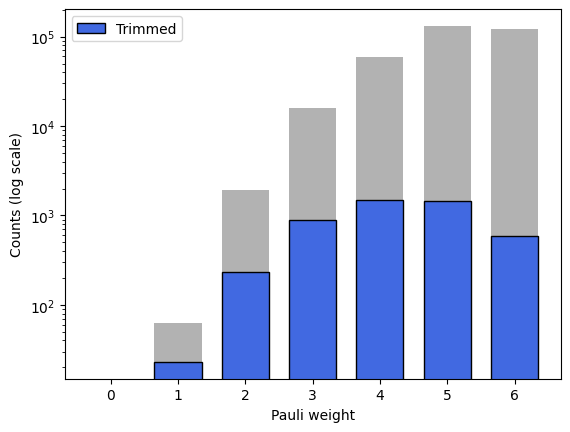

In [27]:
plot_obsW(prop, log=True)

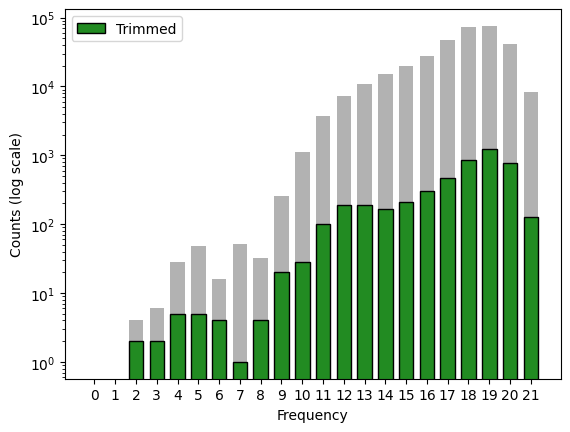

In [28]:
plot_obsF(prop, log=True)

In [30]:
res_dict = {}
theta = np.random.rand(prop.num_params)

progress = tqdm.tqdm(range(len(ks)*len(hs)))

for x, k in enumerate(ks):
    # snake pattern: reverse hs every other k
    hs_iter = hs if x % 2 == 0 else hs[::-1]

    for y, h in enumerate(hs_iter):
        Etrue = get_E(ANNNI_PS, k, h)

        def loss(values):
            return values[0] + k * values[1] + h * values[2]

        res = prop.minimize(loss, theta0=theta, method="ADAM", lr =1e-1, maxiter=1000)

        Evqe = res.fun
        theta = res.x  # carry over optimized theta

        res_dict[(k, h)] = (Etrue, Evqe)
        progress.update(1)

100%|██████████| 441/441 [17:48<00:00,  2.41s/it]

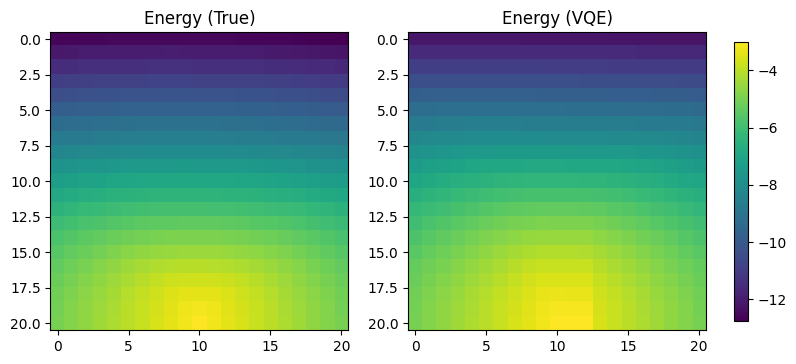

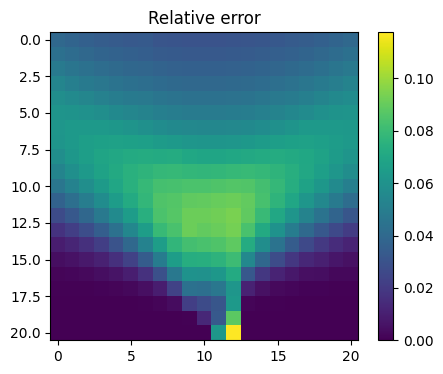

In [31]:
imgE_true = np.zeros((len(ks), len(hs)))
imgE_vqe = np.zeros((len(ks), len(hs)))

for x, k in enumerate(ks):
    for y, h in enumerate(hs):
        imgE_true[x, y] = res_dict[(k, h)][0]
        imgE_vqe[x, y] = res_dict[(k, h)][1]
        
imgE_vqe = np.rot90(imgE_vqe, 1)
imgE_true = np.rot90(imgE_true, 1)
        
fig, ax = plt.subplots(1, 2, figsize=(9, 4))

# Plot images
im0 = ax[0].imshow(imgE_true, cmap='viridis')
ax[0].set_title('Energy (True)')

im1 = ax[1].imshow(imgE_vqe, cmap='viridis')
ax[1].set_title('Energy (VQE)')

# Find min and max values across all images for consistent color scaling
vmin = min(imgE_true.min(), imgE_vqe.min())
vmax = max(imgE_true.max(), imgE_vqe.max())

# Update all plots to use the same scale
for im in [im0, im1]:
    im.set_clim(vmin, vmax)

# Add a single colorbar for the whole figure
fig.colorbar(im1, ax=ax, orientation='vertical', fraction=0.02, pad=0.04)
plt.savefig('vqe_energies.pdf')

plt.show()

plt.figure(figsize=(5, 4))
im2 = plt.imshow(np.abs(imgE_true - imgE_vqe)/np.abs(imgE_true), cmap='viridis')
plt.title("Relative error")
plt.colorbar()
plt.savefig('vqe_relerrors.pdf')
plt.show()
